In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import io
import time
import torch
from torch import nn

In [ ]:
from pathlib import Path
import json
from fastprogress import progress_bar, master_bar
import numpy as np
import pylab as plt

# Generate synthetic embeddings

To control the entropy of our data we can generate two full-size (384-wide) linear projections
from a narrower vector of random numbers. We will have 10 uncorrelated random numbers per sample
but only 2 of them will be our "signal" we want the model to find and extract.

The models will only ever see the linear projections and have to infer the underlying distribution
but since we know how these projection were constructed we know how the best possible performance
looks like.

In [ ]:
# input feature mapping
linear_in = nn.Linear(10, 384)
# output feature mapping
linear_out = nn.Linear(2, 384)
with torch.no_grad():
    # actual data with 10 DoF, normally not available to us
    seed = torch.randn(2000, 1500, 10)
    # it's available representation
    embs_lin = linear_in(seed)
    # the features we care about
    embs_lin_out = linear_out(seed[:,:,:2])

embs_lin.shape, embs_lin_out.shape

(torch.Size([2000, 1500, 384]), torch.Size([2000, 1500, 384]))

### Sanity checks

Explained variance: [0.13453058 0.2508188  0.36526548 0.46971653 0.57267834 0.66591456
 0.7573542  0.84302443 0.92459875 1.        ]


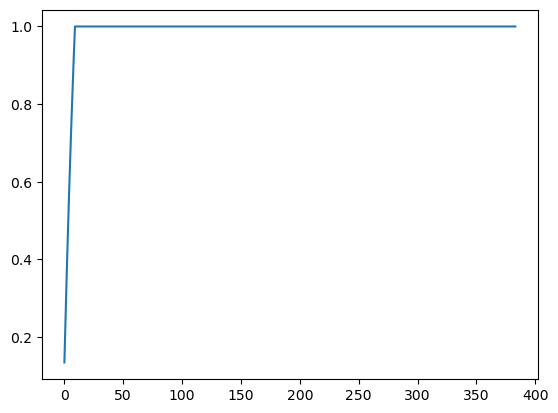

In [ ]:
# check if we can do linear dimentionality reduction on the representation (we can, perfectly)
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(embs_lin[0])
print("Explained variance:", pca.explained_variance_ratio_.cumsum()[:10])
plt.plot(pca.explained_variance_ratio_.cumsum());

Explained variance: [0.53968243 1.        ]


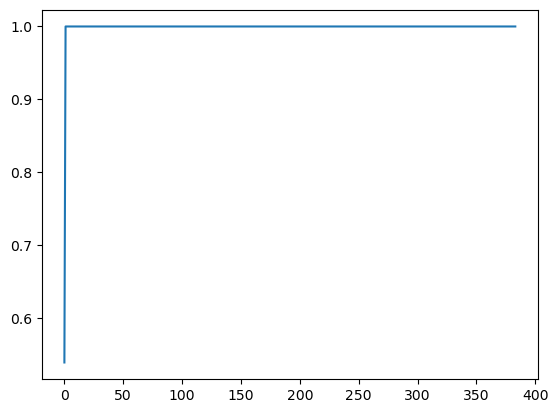

In [ ]:
# check if we can do linear dimentionality reduction on the important features (we can, perfectly)
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(embs_lin_out[0])
print("Explained variance:", pca.explained_variance_ratio_.cumsum()[:2])
plt.plot(pca.explained_variance_ratio_.cumsum());

In [ ]:
# generate an incompressible block of fully random numbers and check it's PCA to get a worse-case baseline
embs_random = torch.randn(2000, 1500, 384)

Explained variance: [0.00588778 0.01158216 0.01725761 0.02292042 0.02850381]


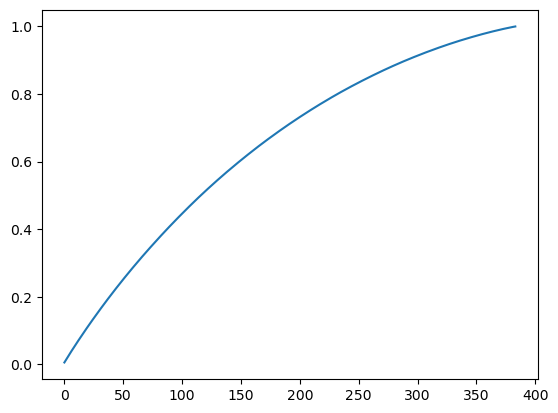

In [ ]:
# check if we can do linear dimentionality reduction (not really)
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(embs_random[0])
print("Explained variance:", pca.explained_variance_ratio_.cumsum()[:5])
plt.plot(pca.explained_variance_ratio_.cumsum());

In [ ]:
# we quantize the seed that was used to create embs_lin_out to estimate the best-case quantization error
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=512,
                          random_state=0,
                          batch_size=8000,
                          n_init="auto")
kmeans.fit(seed.view(-1,10)[:,:2])

MiniBatchKMeans(batch_size=8000, n_clusters=512, n_init='auto', random_state=0)

In [ ]:
# calculate the quantization error
clc = kmeans.cluster_centers_.astype(np.float16)
vq_seed = clc[kmeans.predict(seed.view(-1,10)[:,:2])]
(torch.tensor(vq_seed).view(seed[:,:,:2].shape) - seed[:,:,:2]).abs().mean()

tensor(0.0506)

In [ ]:
# quantization error after projecting back into the important features space
# this is what we can measure at the output of a model in real life (seed is not available)
vq_emb_lin_out = linear_out(torch.tensor(vq_seed).view(seed[:,:,:2].shape).to(torch.float32))
(vq_emb_lin_out - embs_lin_out).abs().mean()

tensor(0.0276, grad_fn=<MeanBackward0>)

In [ ]:
# make a function so we can test this over different codebook sizes
def calculate_features_vq_error(data, n_codes=512):
    from sklearn.cluster import MiniBatchKMeans
    kmeans = MiniBatchKMeans(n_clusters=n_codes,
                              random_state=0,
                              batch_size=8000,
                              n_init="auto")
    kmeans.fit(data)
    clc = kmeans.cluster_centers_.astype(np.float32)
    vq_data = clc[kmeans.predict(data)]
    vq_emb_lin_out = linear_out(torch.tensor(vq_data.view(data.shape))).to(torch.float32)
    return (vq_emb_lin_out - embs_lin_out).abs().mean()

In [ ]:
# we have 2 real degrees of freedom so we have to spend 2 bits to halve the quantization error
n_codes = np.geomspace(64, 4096, 7)
errs = [calculate_kmeans_vq_error(seed[:,:,:2].view(-1,2), n_codes=int(x)).item() for x in n_codes]
errs

[0.13899807631969452,
 0.1011425033211708,
 0.0706859827041626,
 0.05043591558933258,
 0.035338956862688065,
 0.024937380105257034,
 0.017967119812965393]

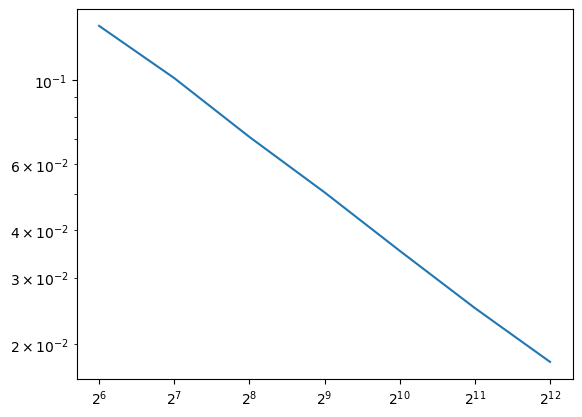

In [ ]:
plt.loglog(n_codes, errs)
plt.gca().set_xscale("log", base=2)

# Simplify the embeddings with a VQ bottleneck

In [ ]:
Let's start with a simple model with linear transformations in and out of a VQ unit.

In [ ]:
from torch import nn
from vector_quantize_pytorch import VectorQuantize

class VQBottleneckLinear(nn.Module):
    def __init__(self, width=384, vq_codes=512,
                 codebook_dim=2, threshold_ema_dead_code=2, use_cosine_sim = False):
        super(VQBottleneckLinear, self).__init__()
        self.vq_codes = vq_codes
        
        # the linear layers will be created automatically because codebook_dim != dim
        self.vq = VectorQuantize(
            dim = width,
            codebook_size = vq_codes,
            decay = 0.8,
            commitment_weight = 1.,
            threshold_ema_dead_code = threshold_ema_dead_code,
            use_cosine_sim = use_cosine_sim,
            codebook_dim = codebook_dim,
        )
        
    def forward(self, xin, quantize=False):
        quantized, self.indices, self.commit_loss = self.vq(xin)
        self.err = (xin - quantized).abs().mean()
        return quantized

In [ ]:
# simple training code with somewhat fancy plots
import torch.optim as optim
import torch.nn.functional as F
import random
import IPython

def train(vqmodel, xs, ys, split=0.2, Loss=nn.L1Loss(), lr=0.01, epochs=10):
    optimizer = optim.SGD(vqmodel.parameters(), lr=lr, momentum=0.9)

    idxs = list(range(len(xs)))
    random.shuffle(idxs)
    val_n = int(split * len(idxs))
    train_idxs, val_idxs = idxs[:-val_n], idxs[-val_n:]

    gs = plt.GridSpec(1, 2, width_ratios=[3, 1])
    gs2 = gs[1].subgridspec(2, 1)
    graph_fig = plt.figure(figsize=(10,4))
    loss_p = graph_fig.add_subplot(gs[0])
    vq_p = graph_fig.add_subplot(gs2[0])
    codebook_p = graph_fig.add_subplot(gs2[1])
    graph_out = display(graph_fig, display_id=True, clear=True)
    
    it = 0
    max_vq_usage = 5
    vq_range = torch.tensor([-2,2,-2,2])
    its = []
    train_losses = []
    val_losses = []
    mb = master_bar(range(epochs))
    mb.write(["train", "val", "q err", "used codes"], table=True)
    for epoch in mb:
        running_loss = []
        val_loss = 0
        bar = progress_bar(train_idxs, parent=mb)
        for step,i in enumerate(bar):
            # zero the parameter gradients
            optimizer.zero_grad()

            ps = vqmodel(xs[i].cuda())
            loss = Loss(ps, ys[i].cuda()) + vqmodel.commit_loss
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss.append(loss.item())
            if it % 100 == 0:
                its.append(it)
                train_losses.append(loss.item())
                vqmodel.eval()
                with torch.no_grad():
                    loss = 0
                    commit_loss = 0
                    err = 0
                    for i in val_idxs:
                        ps = vqmodel(xs[i].cuda())
                        loss += Loss(ps, ys[i].cuda()).item()
                        commit_loss += vqmodel.commit_loss.item()
                        err += vqmodel.err.item()
                    used_codes = (vqmodel.vq._codebook.cluster_size > 0.1).sum()
                    N = len(val_idxs)
                    loss /= N; commit_loss /= N; err /= N;
                vqmodel.train()
                val_losses.append(loss)
                loss_p.clear()
                loss_p.plot(its, train_losses)
                loss_p.plot(its, val_losses)
                loss_p.set_xlim(0, epochs * len(train_idxs))
                loss_p.set_yscale('log')
                cls = vqmodel.vq._codebook.cluster_size
                max_vq_usage = max_vq_usage * 0.9 + 0.1 * max(max_vq_usage, cls.max().item())
                vq_p.clear()
                vq_p.fill_between(range(cls.shape[1]), 0, torch.sort(cls, descending=True).values.cpu().numpy()[0])
                vq_p.margins(0,0)
#                 vq_p.set_yticks([])
                vq_p.spines['top'].set_visible(False)
                vq_p.spines['right'].set_visible(False)
                vq_p.spines['bottom'].set_visible(False)
                vq_p.spines['left'].set_visible(False)
                vq_p.set_ylim(0, max_vq_usage)
                cd = vqmodel.vq.codebook
                vq_range = vq_range * 0.8 + 0.2 * torch.tensor([cd[:,0].min(), cd[:,0].max(), cd[:,1].min(), cd[:,1].max()])
                max_vq_usage = max_vq_usage * 0.8 + 0.2 * max(max_vq_usage, cls.max().item())
                codebook_p.clear()
                codebook_p.scatter(vqmodel.vq.codebook[:,0].cpu(), vqmodel.vq.codebook[:,1].cpu(), s=vqmodel.vq._codebook.cluster_size.cpu(), alpha=.2)
                codebook_p.set_xlim(*vq_range[0:2])
                codebook_p.set_ylim(*vq_range[2:4])
                graph_out.update(graph_fig)

            it += 1
            wnd = running_loss[-100:]
            bar.comment = f"#{epoch+1}/{epochs} loss: {sum(wnd) / len(wnd):.3f} commit: {commit_loss:.3f} quant: {err:.3f} vq usage: {used_codes:.3f}"
        mb.write([f"{train_losses[-1]:.3f}", f"{val_losses[-1]:.3f}", f"{err:.3f}", used_codes], table=True)
    graph_out.update(IPython.display.HTML(''))

### Verify that the input features are incompressible (10 DoF)

In [ ]:
# trivial baseline (what we get when we always predict the average embedding)
(embs_random - embs_random.mean()).abs().mean()

tensor(0.7979)

train,val,q err,used codes
0.832,0.832,0.832,512
0.815,0.814,0.814,512
0.805,0.805,0.805,512
0.801,0.801,0.801,512
0.798,0.798,0.798,512


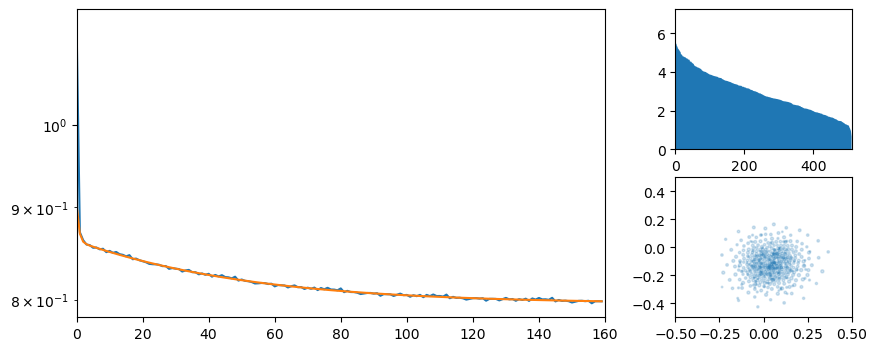

In [ ]:
vqmodel = VQBottleneckLinear().cuda()
train(vqmodel, embs_random, embs_random, epochs=5)

### Extract the important features from the noisy embeddings

In [ ]:
# baseline 1
(embs_lin - embs_lin.mean()).abs().mean()

tensor(0.4787)

train,val,q err,used codes
0.533,0.534,0.534,512
0.465,0.466,0.540,512
0.425,0.426,0.568,512
0.379,0.381,0.601,512
0.324,0.326,0.630,512
0.277,0.278,0.657,512
0.224,0.222,0.683,512
0.154,0.150,0.701,512
0.088,0.083,0.718,512
0.049,0.042,0.733,512


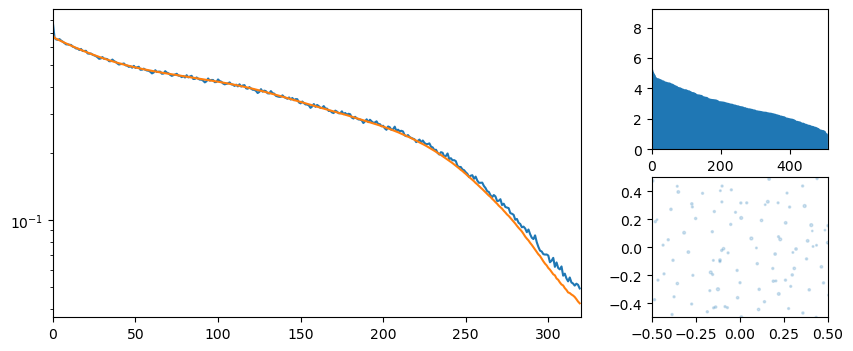

In [ ]:
vqmodel = VQBottleneckLinear().cuda()
train(vqmodel, embs_lin, embs_lin_out)

train,val,q err,used codes
0.541,0.526,0.541,2023
0.475,0.459,0.551,2037
0.439,0.423,0.578,2035
0.393,0.378,0.612,2032
0.317,0.304,0.653,2035
0.218,0.210,0.682,2039
0.117,0.112,0.705,2038
0.053,0.049,0.723,2041
0.025,0.022,0.736,2038
0.019,0.016,0.739,2039


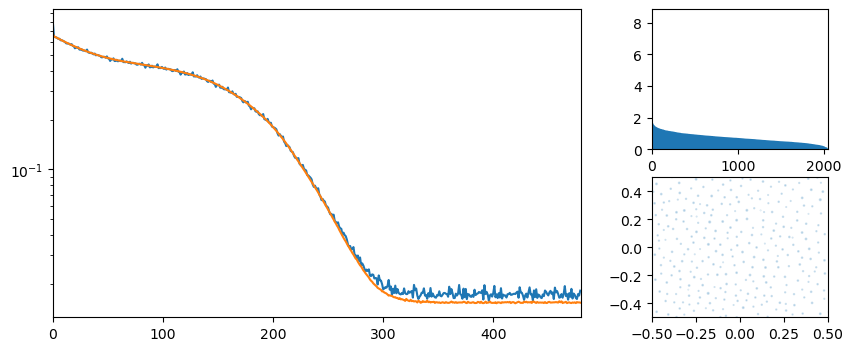

In [ ]:
# let's bump up the codebook size and train a bit longer
vqmodel = VQBottleneckLinear(vq_codes=2048, threshold_ema_dead_code=0.1).cuda()
train(vqmodel, embs_lin, embs_lin_out, epochs=15)

# the result (0.015) is a bit better than when quantizing the seed directly (0.025)!

### Extract the important features from the noisy embeddings with a neural network (with ReLUs)

In [ ]:
from torch import nn
from vector_quantize_pytorch import VectorQuantize

class VQBottleneckNonlinear(nn.Module):
    def __init__(self, width=384, vq_codes=512, depth=2,
                 codebook_dim=2, threshold_ema_dead_code=2, use_cosine_sim = False):
        super(VQBottleneckNonlinear, self).__init__()
        self.vq_codes = vq_codes
        
        # do not add BatchNorms here, they ruin everything
        self.in_layers = nn.Sequential(*[
            nn.Linear(width, width),
            nn.ReLU(),
            nn.Dropout1d(),
        ]*depth)
        
        self.vq = VectorQuantize(
            dim = width,
            codebook_size = vq_codes, # codebook size
            decay = 0.8,              # the exponential moving average decay, lower means the dictionary will change faster
            commitment_weight = 1.,   # the weight on the commitment loss
            threshold_ema_dead_code = threshold_ema_dead_code,
            use_cosine_sim = use_cosine_sim,
            codebook_dim = codebook_dim,
        )

        self.out_layers = nn.Sequential(*[
            nn.ReLU(),
            nn.Dropout1d(),
            nn.Linear(width, width),
        ]*depth)

    def forward(self, x, quantize=False):
        xin = self.in_layers(x) + x
        x, self.indices, self.commit_loss = self.vq(xin)
        self.err = (xin - x).abs().mean()
        x = self.out_layers(x) + x
        return x

train,val,q err,used codes
0.069,0.058,0.689,1939
0.034,0.031,0.704,1904
0.031,0.028,0.708,1957
0.028,0.026,0.702,1979
0.028,0.025,0.703,1964
0.027,0.025,0.702,1968
0.026,0.024,0.701,1956
0.025,0.023,0.701,1982
0.024,0.023,0.700,1987
0.024,0.022,0.701,1973


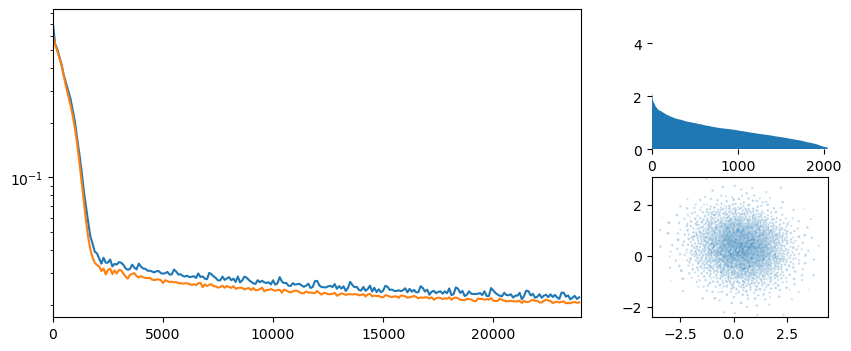

In [ ]:
vqmodel = VQBottleneckNonlinear(codebook_dim=16, vq_codes=2048, threshold_ema_dead_code=0.1).cuda()
train(vqmodel, embs_lin, embs_lin_out, epochs=15)
# a little bit worse but still better than the baseline

train,val,q err,used codes
0.383,0.359,0.572,2033
0.339,0.332,0.560,2041
0.319,0.312,0.566,2038
0.287,0.282,0.589,2040
0.236,0.232,0.610,2044
0.171,0.172,0.629,2038
0.108,0.112,0.652,2041
0.054,0.062,0.680,2037
0.026,0.038,0.697,2034
0.019,0.033,0.701,2039


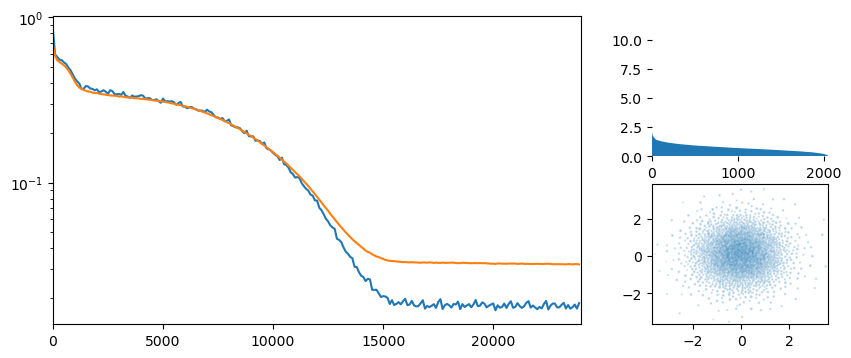

In [ ]:
# forcing the codebook embeddings to only 2 dimensions makes it a bit worse (and it overfits)
vqmodel = VQBottleneckNonlinear(codebook_dim=2, vq_codes=2048, threshold_ema_dead_code=0.1).cuda()
train(vqmodel, embs_lin, embs_lin_out, epochs=15)

### Extract the important features from the noisy embeddings with a transformer (same as Whisper encoder)

In [ ]:
# this is an overkill bit we want to verify that we can train the Whisper transformer encoder
# with our training setup
import whisper
from torch import nn
from vector_quantize_pytorch import VectorQuantize

class LayerNorm(nn.LayerNorm):
    def forward(self, x):
        return super().forward(x.float()).type(x.dtype)

class VQBottleneckTransformer(nn.Module):
    def __init__(self, width=384, vq_codes=512, depth=1, n_head=2,
                 codebook_dim=2, threshold_ema_dead_code=2, use_cosine_sim = False):
        super(VQBottleneckTransformer, self).__init__()
        self.vq_codes = vq_codes
        
        self.in_blocks = nn.Sequential(*[
            whisper.model.ResidualAttentionBlock(width, n_head) for _ in range(depth)
        ])
        self.ln_vq = LayerNorm(width)

        self.vq = VectorQuantize(
            dim = width,
            codebook_size = vq_codes, # codebook size
            decay = 0.8,              # the exponential moving average decay, lower means the dictionary will change faster
            commitment_weight = 1.,   # the weight on the commitment loss
            threshold_ema_dead_code = threshold_ema_dead_code,
            use_cosine_sim = use_cosine_sim,
            codebook_dim = codebook_dim,
        )
        
        self.out_blocks = nn.Sequential(*[
            whisper.model.ResidualAttentionBlock(width, n_head) for _ in range(depth)
        ])
        self.ln_post = LayerNorm(width)
                
    def forward(self, xin, quantize=False):
        x = self.ln_vq(self.in_blocks(xin.unsqueeze(0)))
        quantized, self.indices, self.commit_loss = self.vq(x)
        x = self.ln_post(self.out_blocks(quantized))
        self.err = torch.tensor(torch.nan)
        return x.squeeze(0)

train,val,q err,used codes
0.040,0.038,nan,2028
0.035,0.031,nan,2016
0.035,0.030,nan,2017
0.032,0.027,nan,2012
0.033,0.026,nan,2002
0.033,0.024,nan,2005
0.030,0.023,nan,1987
0.030,0.023,nan,1989
0.028,0.023,nan,1997
0.027,0.022,nan,1989


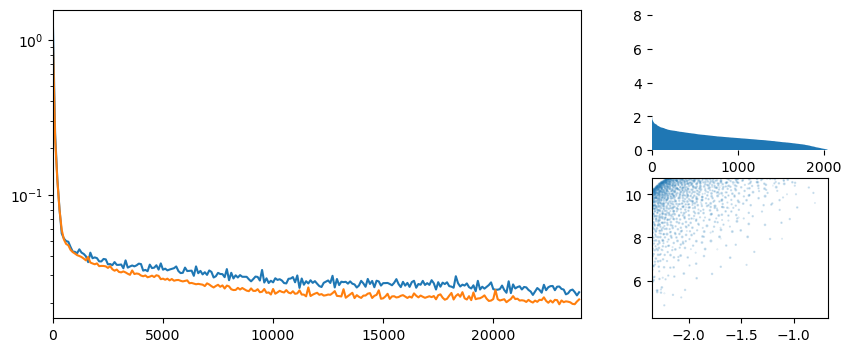

In [ ]:
vqmodel = VQBottleneckTransformer(codebook_dim=16, vq_codes=2048, threshold_ema_dead_code=0.1).cuda()
train(vqmodel, embs_lin, embs_lin_out, epochs=15)
# we get the same good result as with a simple NN (although the embedding space looks a lot fancier ;)